## 1. 程序初始化
第1步：安装基础依赖

In [ ]:
!pip install -r requirements.txt

第2步：导入相关的库

In [2]:
import gym
import sys
import time
import logging
import argparse
import itertools
from six import StringIO
from random import sample, randint
from gym import spaces
from gym.utils import seeding
import numpy as np
import torch
import torch.nn as nn
from PIL import Image, ImageDraw
from IPython import display
import matplotlib.pyplot as plt

## 2. 创建环境
2048游戏环境继承于gym.Env，主要几个部分：

init函数：定义动作空间、状态空间和游戏基本设置
step函数：与环境交互，获取动作并执行，返回状态、奖励、是否结束和补充信息
reset函数：一局结束后，重置环境
render函数：绘图，可视化环境

In [2]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)


class IllegalMove(Exception):
    pass


def stack(flat, layers=16):
    """Convert an [4, 4] representation into [4, 4, layers] with one layers for each value."""
    # representation is what each layer represents
    representation = 2 ** (np.arange(layers, dtype=int) + 1)

    # layered is the flat board repeated layers times
    layered = np.repeat(flat[:, :, np.newaxis], layers, axis=-1)

    # Now set the values in the board to 1 or zero depending whether they match representation.
    # Representation is broadcast across a number of axes
    layered = np.where(layered == representation, 1, 0)

    return layered


class Game2048Env(gym.Env):
    metadata = {'render.modes': ['ansi', 'human', 'rgb_array']}

    def __init__(self):
        # Definitions for game. Board must be square.
        self.size = 4
        self.w = self.size
        self.h = self.size
        self.squares = self.size * self.size

        # Maintain own idea of game score, separate from rewards
        self.score = 0

        # Members for gym implementation
        self.action_space = spaces.Discrete(4)
        # Suppose that the maximum tile is as if you have powers of 2 across the board.
        layers = self.squares
        self.observation_space = spaces.Box(0, 1, (self.w, self.h, layers), dtype=np.int32)
        self.set_illegal_move_reward(-100)
        self.set_max_tile(None)

        # Size of square for rendering
        self.grid_size = 70

        # Initialise seed
        self.seed()

        # Reset ready for a game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def set_illegal_move_reward(self, reward):
        """Define the reward/penalty for performing an illegal move. Also need
            to update the reward range for this."""
        # Guess that the maximum reward is also 2**squares though you'll probably never get that.
        # (assume that illegal move reward is the lowest value that can be returned
        self.illegal_move_reward = reward
        self.reward_range = (self.illegal_move_reward, float(2 ** self.squares))

    def set_max_tile(self, max_tile):
        """Define the maximum tile that will end the game (e.g. 2048). None means no limit.
           This does not affect the state returned."""
        assert max_tile is None or isinstance(max_tile, int)
        self.max_tile = max_tile

    # Implement gym interface
    def step(self, action):
        """Perform one step of the game. This involves moving and adding a new tile."""
        logging.debug("Action {}".format(action))
        score = 0
        done = None
        info = {
            'illegal_move': False,
        }
        try:
            score = float(self.move(action))
            self.score += score
            assert score <= 2 ** (self.w * self.h)
            self.add_tile()
            done = self.isend()
            reward = float(score)
        except IllegalMove:
            logging.debug("Illegal move")
            info['illegal_move'] = True
            done = True
            reward = self.illegal_move_reward

        # print("Am I done? {}".format(done))
        info['highest'] = self.highest()

        # Return observation (board state), reward, done and info dict
        return stack(self.Matrix), reward, done, info

    def reset(self):
        self.Matrix = np.zeros((self.h, self.w), np.int32)
        self.score = 0

        logging.debug("Adding tiles")
        self.add_tile()
        self.add_tile()

        return stack(self.Matrix)

    def render(self, mode='human'):
        if mode == 'rgb_array':
            black = (0, 0, 0)
            grey = (200, 200, 200)
            white = (255, 255, 255)
            tile_colour_map = {
                2: (255, 255, 255),
                4: (255, 248, 220),
                8: (255, 222, 173),
                16: (244, 164, 96),
                32: (205, 92, 92),
                64: (240, 255, 255),
                128: (240, 255, 240),
                256: (193, 255, 193),
                512: (154, 255, 154),
                1024: (84, 139, 84),
                2048: (139, 69, 19),
                4096: (178, 34, 34),
            }
            grid_size = self.grid_size

            # Render with Pillow
            pil_board = Image.new("RGB", (grid_size * 4, grid_size * 4))
            draw = ImageDraw.Draw(pil_board)
            draw.rectangle([0, 0, 4 * grid_size, 4 * grid_size], grey)

            for y in range(4):
                for x in range(4):
                    o = self.get(y, x)
                    if o:
                        draw.rectangle([x * grid_size, y * grid_size, (x + 1) * grid_size, (y + 1) * grid_size],
                                       tile_colour_map[o])
                        bbox = draw.textbbox((x, y), str(o))
                        text_x_size = bbox[2] - bbox[0]
                        text_y_size = bbox[3] - bbox[1]
    
                        draw.text((x * grid_size + (grid_size - text_x_size) // 2,
                                   y * grid_size + (grid_size - text_y_size) // 2), str(o), fill=black)
                        assert text_x_size < grid_size
                        assert text_y_size < grid_size

            return np.asarray(pil_board)

        outfile = StringIO() if mode == 'ansi' else sys.stdout
        s = 'Score: {}\n'.format(self.score)
        s += 'Highest: {}\n'.format(self.highest())
        npa = np.array(self.Matrix)
        grid = npa.reshape((self.size, self.size))
        s += "{}\n".format(grid)
        outfile.write(s)
        return outfile

    # Implement 2048 game
    def add_tile(self):
        """Add a tile, probably a 2 but maybe a 4"""
        possible_tiles = np.array([2, 4])
        tile_probabilities = np.array([0.9, 0.1])
        val = self.np_random.choice(possible_tiles, 1, p=tile_probabilities)[0]
        empties = self.empties()
        assert empties.shape[0]
        empty_idx = self.np_random.choice(empties.shape[0])
        empty = empties[empty_idx]
        logging.debug("Adding %s at %s", val, (empty[0], empty[1]))
        self.set(empty[0], empty[1], val)

    def get(self, x, y):
        """Return the value of one square."""
        return self.Matrix[x, y]

    def set(self, x, y, val):
        """Set the value of one square."""
        self.Matrix[x, y] = val

    def empties(self):
        """Return a 2d numpy array with the location of empty squares."""
        return np.argwhere(self.Matrix == 0)

    def highest(self):
        """Report the highest tile on the board."""
        return np.max(self.Matrix)

    def move(self, direction, trial=False):
        """Perform one move of the game. Shift things to one side then,
        combine. directions 0, 1, 2, 3 are up, right, down, left.
        Returns the score that [would have] got."""
        if not trial:
            if direction == 0:
                logging.debug("Up")
            elif direction == 1:
                logging.debug("Right")
            elif direction == 2:
                logging.debug("Down")
            elif direction == 3:
                logging.debug("Left")

        changed = False
        move_score = 0
        dir_div_two = int(direction / 2)
        dir_mod_two = int(direction % 2)
        shift_direction = dir_mod_two ^ dir_div_two  # 0 for towards up left, 1 for towards bottom right

        # Construct a range for extracting row/column into a list
        rx = list(range(self.w))
        ry = list(range(self.h))

        if dir_mod_two == 0:
            # Up or down, split into columns
            for y in range(self.h):
                old = [self.get(x, y) for x in rx]
                (new, ms) = self.shift(old, shift_direction)
                move_score += ms
                if old != new:
                    changed = True
                    if not trial:
                        for x in rx:
                            self.set(x, y, new[x])
        else:
            # Left or right, split into rows
            for x in range(self.w):
                old = [self.get(x, y) for y in ry]
                (new, ms) = self.shift(old, shift_direction)
                move_score += ms
                if old != new:
                    changed = True
                    if not trial:
                        for y in ry:
                            self.set(x, y, new[y])
        if changed != True:
            raise IllegalMove

        return move_score

    def combine(self, shifted_row):
        """Combine same tiles when moving to one side. This function always
           shifts towards the left. Also count the score of combined tiles."""
        move_score = 0
        combined_row = [0] * self.size
        skip = False
        output_index = 0
        for p in pairwise(shifted_row):
            if skip:
                skip = False
                continue
            combined_row[output_index] = p[0]
            if p[0] == p[1]:
                combined_row[output_index] += p[1]
                move_score += p[0] + p[1]
                # Skip the next thing in the list.
                skip = True
            output_index += 1
        if shifted_row and not skip:
            combined_row[output_index] = shifted_row[-1]

        return (combined_row, move_score)

    def shift(self, row, direction):
        """Shift one row left (direction == 0) or right (direction == 1), combining if required."""
        length = len(row)
        assert length == self.size
        assert direction == 0 or direction == 1

        # Shift all non-zero digits up
        shifted_row = [i for i in row if i != 0]

        # Reverse list to handle shifting to the right
        if direction:
            shifted_row.reverse()

        (combined_row, move_score) = self.combine(shifted_row)

        # Reverse list to handle shifting to the right
        if direction:
            combined_row.reverse()

        assert len(combined_row) == self.size
        return (combined_row, move_score)

    def isend(self):
        """Has the game ended. Game ends if there is a tile equal to the limit
           or there are no legal moves. If there are empty spaces then there
           must be legal moves."""

        if self.max_tile is not None and self.highest() == self.max_tile:
            return True

        for direction in range(4):
            try:
                self.move(direction, trial=True)
                # Not the end if we can do any move
                return False
            except IllegalMove:
                pass
        return True

    def get_board(self):
        """Retrieve the whole board, useful for testing."""
        return self.Matrix

    def set_board(self, new_board):
        """Retrieve the whole board, useful for testing."""
        self.Matrix = new_board

## 3.定义神经网络
分别为文献中提到的网络（前者）以及我自己设计的网络（后者）
相较而言，后者参数量更小，也更好训练一些

In [ ]:
class Net(nn.Module):
    # obs是状态空间输入（4x4），available_actions_count为动作输出维度（4）
    # 输入：4维张量 (batch_size, 4, 4, channels)
    # 输出：2维张量 (batch_size, available_actions_count)
    def __init__(self, obs, available_actions_count):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(obs, 128, kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(128, 128, kernel_size=(2, 2))
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, available_actions_count)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x, 1)   # 展平特征图
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
class Net(nn.Module):
    # obs是状态空间输入，available_actions_count为动作输出维度
    # 输入：4维张量 (batch_size, 4, 4, channels)
    # 输出：2维张量 (batch_size, available_actions_count)
    def __init__(self, obs, available_actions_count):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(obs, 128, kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=2, stride=1)
        self.conv3 = nn.Conv2d(64, 16, kernel_size=2, stride=1)
        self.fc1 = nn.Linear(16, available_actions_count)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.fc1(x.view(x.shape[0], -1))
        return x

## 4.定义DQN算法
DQN算法分了两部分构造：①算法逻辑本身  ②Replay Buffer部分

In [4]:
class DQN:
    def __init__(self, args, obs_dim, action_dim):
        # 是否加载预训练模型
        if args.pre_train_model:
            print("Loading model from: ", args.pre_train_model)
            self.behaviour_model = torch.load(args.pre_train_model).to(device)
            # 如果采用Nature DQN，则需要额外定义target_network
            self.target_model = torch.load(args.pre_train_model).to(device)
        else:
            self.behaviour_model = Net(obs_dim, action_dim).to(device)
            self.target_model = Net(obs_dim, action_dim).to(device)

        self.optimizer = torch.optim.Adam(self.behaviour_model.parameters(), args.learning_rate)
        
        # 损失函数
        self.criterion = nn.MSELoss()
        self.losses=[]
        
        # 动作维度
        self.action_dim = action_dim
        # 统计学习步数
        self.learn_step_counter = 0
        self.args = args
        self.epsilon=args.epsilon

    def learn(self, buffer):
        # 当replaybuffer中存储的数据大于batchsize时，从中随机采样一个batch的数据学习
        if buffer.size >= self.args.batch_size:
            # 更新target_model的参数
            if self.learn_step_counter % args.target_update_freq == 0:
                self.target_model.load_state_dict(self.behaviour_model.state_dict())
            self.learn_step_counter += 1

            # 从replaybuffer中随机采样batch_size个五元组（当前观测值，动作，下一个观测值，是否一局结束，奖励值）
            s1, a, s2, done, r = buffer.get_sample(self.args.batch_size)
            s1 = torch.FloatTensor(s1).to(device)
            s2 = torch.FloatTensor(s2).to(device)
            r = torch.FloatTensor(r).to(device)
            a = torch.LongTensor(a).to(device)

            if args.use_nature_dqn:
                q = self.target_model(s2).detach()
            else:
                q = self.behaviour_model(s2)
            # 每个动作的q值=r+gamma*(1-0或1)*q_max
            target_q = r + torch.FloatTensor(args.gamma * (1 - done)).to(device) * q.max(1)[0]
            
            
            target_q = target_q.view(args.batch_size, 1)
            # torch.reshape(a, shape=(a.size()[0], -1)) = (batch_size, 1)
            # 从模型输出中的第一个维度进行处理，找到s1状态下的动作值
            eval_q = self.behaviour_model(s1).gather(1, torch.reshape(a, shape=(a.size()[0], -1)))
            # 计算损失函数
            # self.criterion = nn.MSELoss()
            loss = self.criterion(eval_q, target_q)
            self.losses.append(loss.item())  # 记录损失

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if args.epsilon_decay_mode == 'exponential':
                self.epsilon *= args.epsilon_decay
            elif args.epsilon_decay_mode == 'linear':
                self.epsilon -= args.epsilon_decay
            self.epsilon = max(self.epsilon, 0.4)  # Ensure a minimum exploration rate
            
            
    def get_action(self, state, explore=True):
        # 判断是否探索，如果探索，则采用贪婪探索策略决定行为
        if explore:
            if np.random.uniform() >= self.epsilon:
                action = randint(0, self.action_dim - 1)
            else:
                # Choose the best action according to the network.
                q = self.behaviour_model(torch.FloatTensor(state).to(device))
                m, index = torch.max(q, 1)
                action = index.data.cpu().numpy()[0]
        else:
            q = self.behaviour_model(torch.FloatTensor(state).to(device))
            m, index = torch.max(q, 1)
            action = index.data.cpu().numpy()[0]

        return action


class ReplayBuffer:
    def __init__(self, buffer_size, obs_space):
        self.s1 = np.zeros(obs_space, dtype=np.float32)
        self.s2 = np.zeros(obs_space, dtype=np.float32)
        self.a = np.zeros(buffer_size, dtype=np.int32)
        self.r = np.zeros(buffer_size, dtype=np.float32)
        self.done = np.zeros(buffer_size, dtype=np.float32)

        # replaybuffer大小
        self.buffer_size = buffer_size
        self.size = 0
        self.pos = 0

    # 不断将数据存储入buffer
    def add_transition(self, s1, action, s2, done, reward):
        self.s1[self.pos] = s1
        self.a[self.pos] = action
        if not done:
            self.s2[self.pos] = s2
        self.done[self.pos] = done
        self.r[self.pos] = reward

        self.pos = (self.pos + 1) % self.buffer_size
        self.size = min(self.size + 1, self.buffer_size)

    # 随机采样一个batchsize
    def get_sample(self, sample_size):
        i = sample(range(0, self.size), sample_size)
        return self.s1[i], self.a[i], self.s2[i], self.done[i], self.r[i]

## 5.训练参数初始化
可以根据自己的需求调整超参数

In [5]:
parser = argparse.ArgumentParser()
# 学习率
parser.add_argument("--learning_rate", type=float, default=0.0001)
# 经验折扣率
parser.add_argument("--gamma", type=float, default=0.99)
# 迭代多少局数
parser.add_argument("--epochs", type=int, default=10000)
# replaybuffer大小
parser.add_argument("--buffer_size", type=int, default=10000)
# batchsize大小
parser.add_argument("--batch_size", type=int, default=128)
# 是否加载预训练模型
parser.add_argument("--pre_train_model", type=str, default=None)
# 是否采用nature dqn
parser.add_argument("--use_nature_dqn", type=bool, default=True)
# 如果采用nature dqn，target模型更新频率
parser.add_argument("--target_update_freq", type=int, default=250)
# 探索epsilon取值
parser.add_argument("--epsilon", type=float, default=0.99)
# 添加新的参数 epsilon_decay，控制衰减速度
parser.add_argument("--epsilon_decay", type=float, default=0.995)
parser.add_argument("--epsilon_decay_mode", type=str, default='exponential')

args, _ = parser.parse_known_args()

## 6.训练模型
初始化环境和算法

In [6]:
# 初始化环境
env = Game2048Env()
device = torch.device("cpu")
# 初始化dqn
# env.observation_space.shape=(4,4,16)
dqn = DQN(args, obs_dim=env.observation_space.shape[2], action_dim=env.action_space.n)
# 初始化replay buffer
memory = ReplayBuffer(buffer_size=args.buffer_size, obs_space=
(args.buffer_size, env.observation_space.shape[0], env.observation_space.shape[1], env.observation_space.shape[2]))

开始训练


training...
Ep:  0
Ep:  100
Ep:  105 | Ep_r:  20.0
current_max_reward 20.0
Ep:  140 | Ep_r:  36.0
current_max_reward 36.0
Ep:  200
Ep:  212 | Ep_r:  140.0
current_max_reward 140.0
Ep:  300
Ep:  400
Ep:  500
Ep:  600
Ep:  700
Ep:  800
Ep:  900
Ep:  910 | Ep_r:  180.0
current_max_reward 180.0
Ep:  1000
Ep:  1019 | Ep_r:  228.0
current_max_reward 228.0
Ep:  1100
Ep:  1200
Ep:  1232 | Ep_r:  256.0
current_max_reward 256.0
Ep:  1300
Ep:  1320 | Ep_r:  268.0
current_max_reward 268.0
Ep:  1323 | Ep_r:  292.0
current_max_reward 292.0
Ep:  1341 | Ep_r:  296.0
current_max_reward 296.0
Ep:  1378 | Ep_r:  452.0
current_max_reward 452.0
Ep:  1399 | Ep_r:  528.0
current_max_reward 528.0
Ep:  1400
Ep:  1405 | Ep_r:  820.0
current_max_reward 820.0
Ep:  1500
Ep:  1501 | Ep_r:  1128.0
current_max_reward 1128.0
Ep:  1600
Ep:  1634 | Ep_r:  1180.0
current_max_reward 1180.0
Ep:  1652 | Ep_r:  1256.0
current_max_reward 1256.0
Ep:  1690 | Ep_r:  1296.0
current_max_reward 1296.0
Ep:  1692 | Ep_r:  1440.0
cur

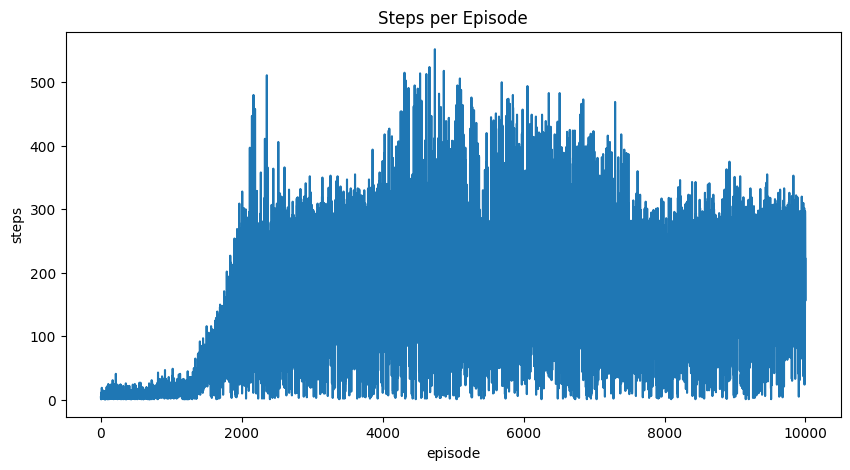

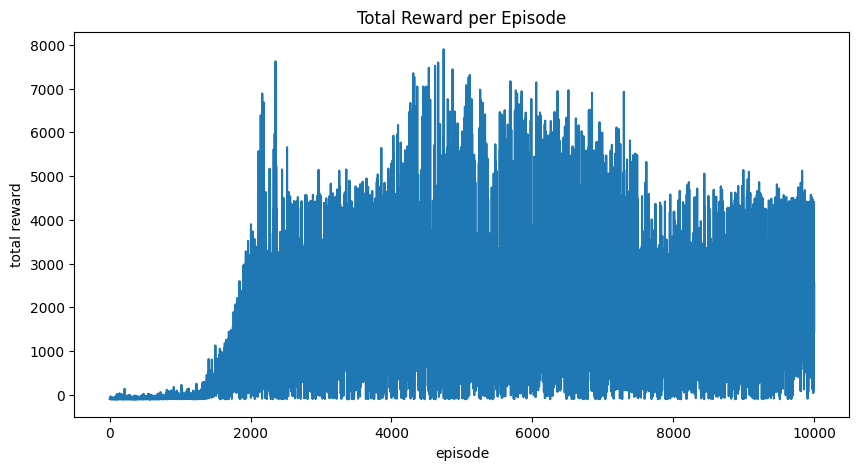

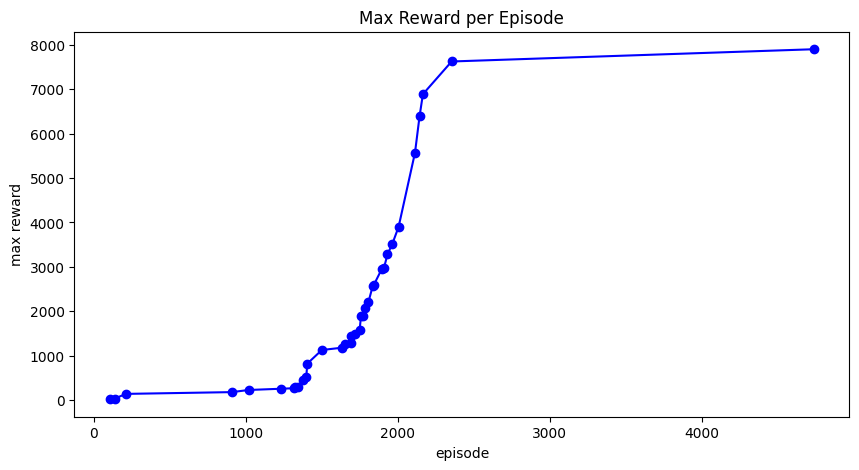

finish! time cost is 13203.123321056366s


In [7]:
print('\ntraining...')
begin_t = time.time()
max_reward = 0
rewards = []  # 记录每一轮的累计奖励
steps = []  # 记录每一轮的步数
losses= []  # 记录每一步的损失
max_rewards = []  # 记录每次达到最大奖励时的current_max_reward
max_episodes = []  # 记录每次达到最大奖励时的i_episode

for i_episode in range(args.epochs):
    args.epsilon = 0.9  # 这里的 0.9 应该设定为你的初始 epsilon 值
    # 每局开始，重置环境
    s = env.reset()
    # 累计奖励值
    ep_r = 0
    step_counter = 0  # 步数计数器
    while True:
        dqn.epsilon=0.99
        # 计算动作
        a = dqn.get_action(np.expand_dims(s, axis=0))
        # 执行动作
        s_, r, done, info = env.step(a)
        # 存储信息
        memory.add_transition(s, a, s_, done, r)
        ep_r += r
        step_counter += 1
        # 学习优化过程
        dqn.learn(memory)
        
        if done:       
            if i_episode%100==0:
                print('Ep: ', i_episode)
            rewards.append(ep_r)  # 记录累计奖励
            steps.append(step_counter)  # 记录步数
            if ep_r > max_reward:
                print('Ep: ', i_episode, '| Ep_r: ', round(ep_r, 2))
                max_reward = ep_r
                print("current_max_reward {}".format(max_reward))
                # 保存模型
                torch.save(dqn.behaviour_model, "2048.pt")
                max_rewards.append(max_reward)  # 记录当前最大奖励
                max_episodes.append(i_episode)  # 记录当前最大奖励对应的i_episode
            break
        s = s_
    
# 绘制步数变化图
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(steps)), steps)
plt.xlabel('episode')
plt.ylabel('steps')
plt.title('Steps per Episode')
plt.show()

# 绘制最终得分变化图
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(rewards)), rewards)
plt.xlabel('episode')
plt.ylabel('total reward')
plt.title('Total Reward per Episode')
plt.show()

# 绘制每次达到最大奖励时的current_max_reward和i_episode
plt.figure(figsize=(10, 5))
plt.plot(max_episodes, max_rewards, 'bo-')
plt.xlabel('episode')
plt.ylabel('max reward')
plt.title('Max Reward per Episode')
plt.show()

print("finish! time cost is {}s".format(time.time() - begin_t))


## 7.使用模型推理游戏

In [ ]:
#加载模型
model = torch.load("2048.pt").to(device)
model.eval()
reward=0
s = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
while True:
    plt.axis("off")
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    s = torch.FloatTensor(np.expand_dims(s, axis=0)).to(device)
    a = torch.argmax(model(s), dim=1).cpu().numpy()[0]
    # take action
    s_, r, done, info = env.step(a)
    reward+=r
    time.sleep(0.1)
    if done:
        break
    s = s_
env.close()
print(reward)
